In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

**Load environment variables from .env file**

In [2]:
load_dotenv('../.venv/.env')

True

**Retrieve database connection details from environment variables**

In [5]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
table_name = 'xdr_data'

**Create the connection string**

In [6]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

**Query the data**

In [7]:
query = 'SELECT * FROM xdr_data'
data = pd.read_sql(query, engine)

**Task 2: User Engagement Analysis**

**Aggregate Metrics per Customer ID (MSISDN)**

In [20]:
# Define DL and UL columns
dl_columns = [
    'Social Media DL (Bytes)', 
    'Google DL (Bytes)', 
    'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 
    'Netflix DL (Bytes)', 
    'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

ul_columns = [
    'Social Media UL (Bytes)', 
    'Google UL (Bytes)', 
    'Email UL (Bytes)', 
    'Youtube UL (Bytes)', 
    'Netflix UL (Bytes)', 
    'Gaming UL (Bytes)', 
    'Other UL (Bytes)'
]

agg_data = data.groupby('MSISDN/Number').agg(
    sessions_frequency=('Bearer Id', 'count'),
    total_duration=('Dur. (ms)', 'sum'),
    **{col: (col, 'sum') for col in dl_columns},  # Sum each DL column
    **{col: (col, 'sum') for col in ul_columns}   # Sum each UL column
)

# Calculate total data volume
agg_data['total_traffic'] = agg_data[dl_columns].sum(axis=1) + agg_data[ul_columns].sum(axis=1)

# Drop the intermediary columns
agg_data = agg_data.drop(columns=dl_columns + ul_columns)

# Top 10 customers per engagement metric
top_sessions = agg_data.nlargest(10, 'sessions_frequency')
top_duration = agg_data.nlargest(10, 'total_duration')
top_traffic = agg_data.nlargest(10, 'total_traffic')

print(top_sessions)
print(top_duration)
print(top_traffic)

               sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
4.188282e+10                 1066    7.255100e+07   9.736730e+11
3.362632e+10                   18    8.791927e+06   1.599664e+10
3.361489e+10                   17    9.966898e+06   1.634152e+10
3.362578e+10                   17    1.855375e+07   1.470127e+10
3.365973e+10                   16    4.035428e+06   1.388841e+10
3.367588e+10                   15    4.865947e+06   1.455618e+10
3.376054e+10                   15    9.279434e+06   1.310481e+10
3.366716e+10                   13    8.744914e+06   1.045593e+10
3.360313e+10                   12    6.287761e+06   1.119890e+10
3.360452e+10                   12    5.207990e+06   9.547813e+09
               sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
4.188282e+10                 1066    7.255100e+07   9.736730e+11
3.362578e+10             

**Task 2.1: Clustering and Analysis**

**Aggregate Metrics per Customer ID (MSISDN)**

In [9]:
# Define DL and UL columns
dl_columns = [
    'Social Media DL (Bytes)', 
    'Google DL (Bytes)', 
    'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 
    'Netflix DL (Bytes)', 
    'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

ul_columns = [
    'Social Media UL (Bytes)', 
    'Google UL (Bytes)', 
    'Email UL (Bytes)', 
    'Youtube UL (Bytes)', 
    'Netflix UL (Bytes)', 
    'Gaming UL (Bytes)', 
    'Other UL (Bytes)'
]

agg_data = data.groupby('MSISDN/Number').agg(
    sessions_frequency=('Bearer Id', 'count'),
    total_duration=('Dur. (ms)', 'sum'),
    **{col: (col, 'sum') for col in dl_columns},  # Sum each DL column
    **{col: (col, 'sum') for col in ul_columns}   # Sum each UL column
)

# Calculate total data volume
agg_data['total_traffic'] = agg_data[dl_columns].sum(axis=1) + agg_data[ul_columns].sum(axis=1)

# Drop the intermediary columns
agg_data = agg_data.drop(columns=dl_columns + ul_columns)

# Top 10 customers per engagement metric
top_sessions = agg_data.nlargest(10, 'sessions_frequency')
top_duration = agg_data.nlargest(10, 'total_duration')
top_traffic = agg_data.nlargest(10, 'total_traffic')

print("Top 10 by Sessions Frequency:\n", top_sessions)
print("\nTop 10 by Total Duration:\n", top_duration)
print("\nTop 10 by Total Traffic:\n", top_traffic)

Top 10 by Sessions Frequency:
                sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
4.188282e+10                 1066    7.255100e+07   9.736730e+11
3.362632e+10                   18    8.791927e+06   1.599664e+10
3.361489e+10                   17    9.966898e+06   1.634152e+10
3.362578e+10                   17    1.855375e+07   1.470127e+10
3.365973e+10                   16    4.035428e+06   1.388841e+10
3.367588e+10                   15    4.865947e+06   1.455618e+10
3.376054e+10                   15    9.279434e+06   1.310481e+10
3.366716e+10                   13    8.744914e+06   1.045593e+10
3.360313e+10                   12    6.287761e+06   1.119890e+10
3.360452e+10                   12    5.207990e+06   9.547813e+09

Top 10 by Total Duration:
                sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
4.188282e+10                 10

**Aggregate User Total Traffic per Application**

In [10]:
# Calculate total traffic per application for each user
app_traffic = data.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum'
})

# Top 10 most engaged users per application
top_social_media = app_traffic.nlargest(10, 'Social Media DL (Bytes)')
top_youtube = app_traffic.nlargest(10, 'Youtube DL (Bytes)')
top_netflix = app_traffic.nlargest(10, 'Netflix DL (Bytes)')

print("Top 10 by Social Media Traffic:\n", top_social_media)
print("\nTop 10 by YouTube Traffic:\n", top_youtube)
print("\nTop 10 by Netflix Traffic:\n", top_netflix)

Top 10 by Social Media Traffic:
                Social Media DL (Bytes)  Youtube DL (Bytes)  \
MSISDN/Number                                                
4.188282e+10              1.937715e+09        1.249464e+10   
3.362632e+10              4.274384e+07        1.640487e+08   
3.376054e+10              3.929765e+07        1.940683e+08   
3.365973e+10              3.490044e+07        1.196581e+08   
3.361489e+10              2.774974e+07        1.998234e+08   
3.362578e+10              2.656412e+07        2.378830e+08   
3.366716e+10              2.375375e+07        1.419727e+08   
3.378632e+10              2.356866e+07        1.181299e+08   
3.366907e+10              2.347705e+07        1.362953e+08   
3.360313e+10              2.277668e+07        1.589767e+08   

               Netflix DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                            
4.188282e+10         1.228898e+10       6.007942e+09      1.904048e+09   


**Normalize Engagement Metrics**

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(agg_data)

**Run K-Means Clustering (k=3)**

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(normalized_data)

**Compute Metrics for Each Cluster**

In [13]:
cluster_metrics = agg_data.groupby('cluster').agg(
    min_sessions=('sessions_frequency', 'min'),
    max_sessions=('sessions_frequency', 'max'),
    avg_sessions=('sessions_frequency', 'mean'),
    total_sessions=('sessions_frequency', 'sum'),
    min_duration=('total_duration', 'min'),
    max_duration=('total_duration', 'max'),
    avg_duration=('total_duration', 'mean'),
    total_duration=('total_duration', 'sum'),
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
)

print(cluster_metrics)

         min_sessions  max_sessions  avg_sessions  total_sessions  \
cluster                                                             
0                   1             7      1.362240          144140   
1                1066          1066   1066.000000            1066   
2                   1            18      4.588517            4795   

         min_duration  max_duration  avg_duration  total_duration  \
cluster                                                             
0        7.142000e+03  7.877820e+05  1.348413e+05    1.426769e+10   
1        7.255100e+07  7.255100e+07  7.255100e+07    7.255100e+07   
2        5.583150e+05  1.855375e+07  1.292961e+06    1.351145e+09   

          min_traffic   max_traffic   avg_traffic  total_traffic  
cluster                                                           
0        5.836229e+07  8.366489e+09  1.248912e+09   1.321486e+14  
1        9.736730e+11  9.736730e+11  9.736730e+11   9.736730e+11  
2        2.060971e+08  1.634152e+10  4.2

**Visualize Results**

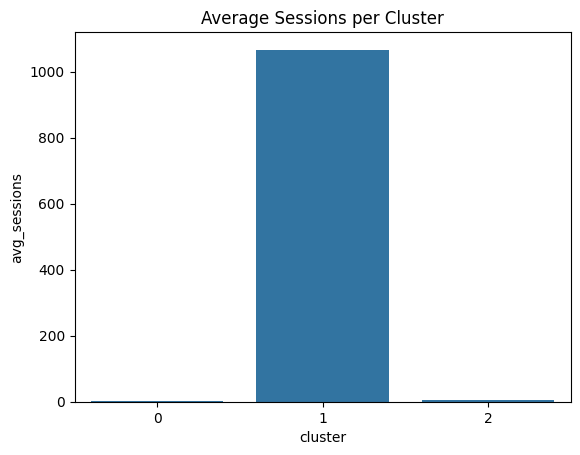

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=cluster_metrics.index, y=cluster_metrics['avg_sessions'])
plt.title('Average Sessions per Cluster')
plt.show()

Elbow Method to Optimize **Elbow Method to Optimize k**

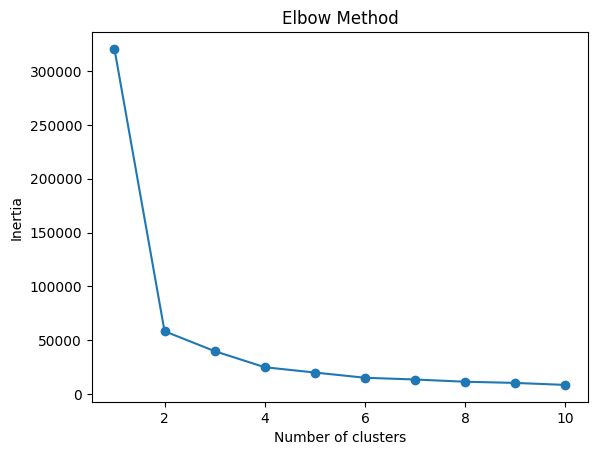

In [15]:
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Aggregate User Total Traffic per Application**

In [16]:
app_traffic = data[['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
                    'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].sum()

top_apps = app_traffic.nlargest(3)

print(top_apps)

Gaming DL (Bytes)     6.330713e+13
Other DL (Bytes)      6.316550e+13
Youtube DL (Bytes)    1.745123e+12
dtype: float64


**Plot Top 3 Applications**

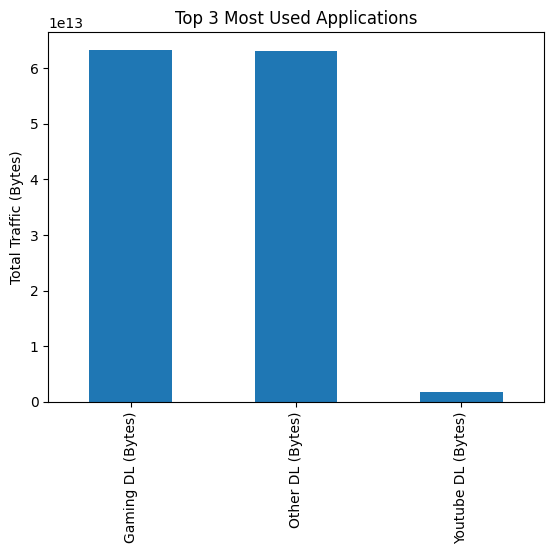

In [17]:
top_apps.plot(kind='bar')
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

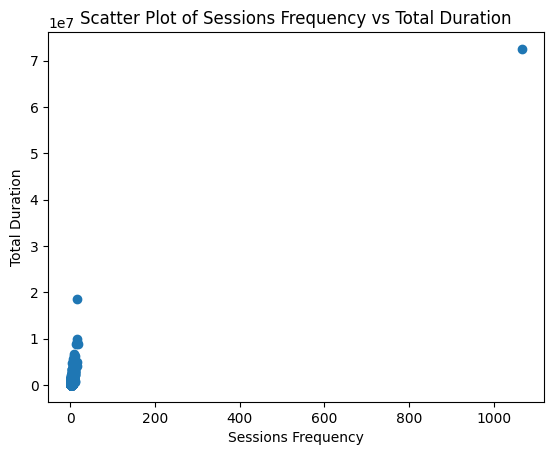

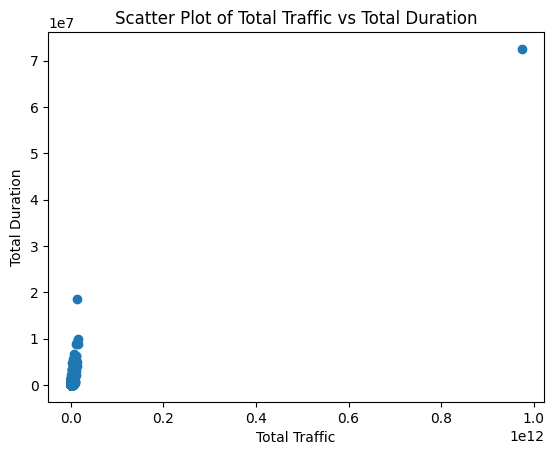

In [22]:
import matplotlib.pyplot as plt

# Scatter plot of sessions frequency vs total duration
plt.scatter(agg_data['sessions_frequency'], agg_data['total_duration'])
plt.xlabel('Sessions Frequency')
plt.ylabel('Total Duration')
plt.title('Scatter Plot of Sessions Frequency vs Total Duration')
plt.show()

# Scatter plot of total traffic vs total duration
plt.scatter(agg_data['total_traffic'], agg_data['total_duration'])
plt.xlabel('Total Traffic')
plt.ylabel('Total Duration')
plt.title('Scatter Plot of Total Traffic vs Total Duration')
plt.show()

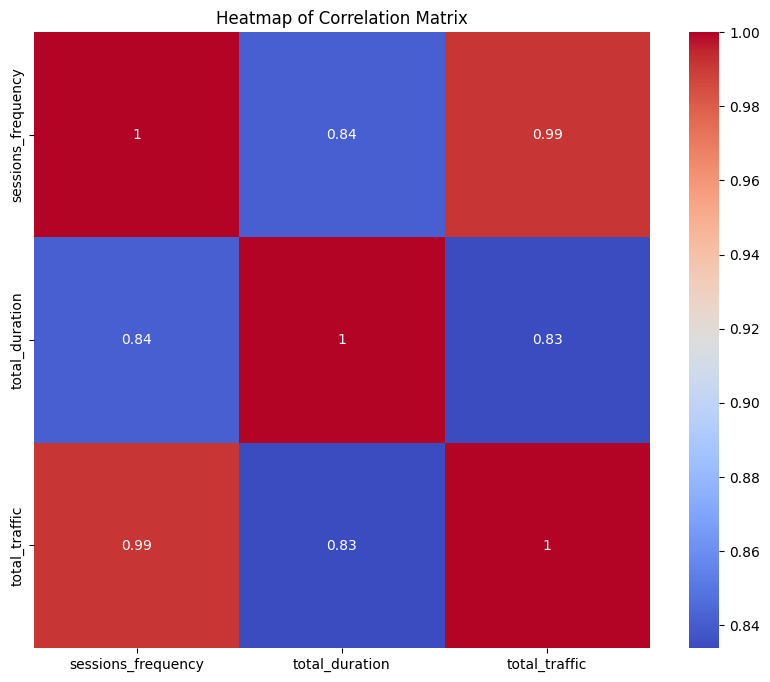

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = agg_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()